# Imports

In [1]:
# Ajouter chemin système pour naviguer d'un dossier à l'autre facilement
import sys
from pathlib import Path
sys.path.append(str(Path('.').absolute().parent))

In [2]:
########## Installations ##########

#pip install plot-keras-history

# Setup particulier à faire sur Mac pour pouvoir faire data augmentation
# idéalement : faire un environnement virtuel (ici on essaiera de faire sans, mais à mettre en place sans faute pour le prochain projet)

# https://developer.apple.com/metal/tensorflow-plugin/
#!pip install tensorflow
#!pip install tensorflow-macos==2.9.0
#!pip install tensorflow-metal==0.5.1

In [3]:
########## Imports ##########
import pandas as pd
import numpy as np
import os
from glob import glob
import time
import pickle
from packages import fonctions, data_preparation, classification_supervisee

import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
%matplotlib inline 
# vérifier si vraiment utile

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn import manifold, decomposition
from sklearn import cluster, metrics

# tensorflow
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.utils import load_img, img_to_array
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
#from keras.optimizers.legacy import Adam

#pip install plot-keras-history
from plot_keras_history import show_history, plot_history

os.environ['TF_KERAS'] = '1'
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
########## Apparence ##########

# Warnings
import warnings
warnings.simplefilter(action = 'ignore')

# Set display preferences
pd.set_option('display.max_row', 250)
pd.set_option('display.max_column', 100)

# Choix d'une palette de couleurs
sns.set_palette('Set2', color_codes = True)
print(sns.color_palette('Set2').as_hex())
sns.set_style('darkgrid')
sns.color_palette()

['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']


[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [6]:
########## Consignes ##########

# Afin d’extraire les features image, il sera nécessaire de mettre en œuvre :
# - un algorithme de type SIFT / ORB / SURF
# - un algorithme de type CNN Transfer Learning.
# Concernant l’approche de type SIFT, je t’invite à regarder le webinaire que nous avons réalisé, disponible dans les ressources

# Préparation des données

In [7]:
########## Import des données ##########

path = '' #-> en local
filepath = os.path.join(path, '../../data/data')

with open(filepath, 'rb') as f:
    data = pickle.load(f)

data.head()

,label_name,image_path,label
0,Home and Kitchen Essential,../../data/Images/55b85ea15a1536d46b7190ad6fff...,3
1,Baby and Personal Care,../../data/Images/7b72c92c2f6c40268628ec5f14c6...,0
2,Home and Kitchen Essential,../../data/Images/d4684dcdc759dd9cdf41504698d7...,3
3,Home and Kitchen Essential,../../data/Images/6325b6870c54cd47be6ebfbffa62...,3
4,Electronics and Accessories,../../data/Images/f355cc1ccb08bd0d283ed979b7ee...,1


In [8]:
path = '' #-> en local
filepath = os.path.join(path, '../../data/df_image')

with open(filepath, 'rb') as f:
    df_image = pickle.load(f)

df_image.head()

,label_name,product_category_tree,image_name,image_path,label
0,Home and Kitchen Essential,"[""Home Furnishing >> Curtains & Accessories >>...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,../../data/Images/55b85ea15a1536d46b7190ad6fff...,3
1,Baby and Personal Care,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",7b72c92c2f6c40268628ec5f14c6d590.jpg,../../data/Images/7b72c92c2f6c40268628ec5f14c6...,0
2,Home and Kitchen Essential,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",d4684dcdc759dd9cdf41504698d737d8.jpg,../../data/Images/d4684dcdc759dd9cdf41504698d7...,3
3,Home and Kitchen Essential,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",6325b6870c54cd47be6ebfbffa620ec7.jpg,../../data/Images/6325b6870c54cd47be6ebfbffa62...,3
4,Electronics and Accessories,"[""Watches >> Wrist Watches >> Camerii Wrist Wa...",f355cc1ccb08bd0d283ed979b7ee7515.jpg,../../data/Images/f355cc1ccb08bd0d283ed979b7ee...,1


In [9]:
path = '' #-> en local
filepath = os.path.join(path, '../../data/df')

with open(filepath, 'rb') as f:
    df = pickle.load(f)

df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,product_specifications,category,category_4,sous_category,sous_ensemble
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Home and Kitchen Essential,Curtains & Accessories,Curtains
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Baby and Personal Care,Baby Bath & Skin,Baby
2,d4684dcdc759dd9cdf41504698d737d8,2016-06-20,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Home and Kitchen Essential,Bed Linen,Bed
3,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,Home and Kitchen Essential,Bed Linen,Bed
4,f355cc1ccb08bd0d283ed979b7ee7515,2015-12-04,http://www.flipkart.com/camerii-wm64-elegance-...,"Camerii WM64 Elegance Analog Watch - For Men,...","[""Watches >> Wrist Watches >> Camerii Wrist Wa...",WATE6Y6D2MZHWGBZ,1099.0,449.0,f355cc1ccb08bd0d283ed979b7ee7515.jpg,False,"Camerii WM64 Elegance Analog Watch - For Men,...",5,5,"{""product_specification""=>[{""key""=>""Chronograp...",Wrist Watches,Electronics and Accessories,Wrist Watches,Wrist


# Etape 2 : classification supervisée
4 approches sont présentées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images
* Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation
* Une approche par  DataSet, avec data augmentation intégrée au modèle : layer en début de modèle


## Création du modèle de classification

## Approche préparation initiale des images

In [10]:
# Séparer "data" en deux morceaux pour avoir data train et data test
data.shape

(904, 3)

In [11]:
data

,label_name,image_path,label
0,Home and Kitchen Essential,../../data/Images/55b85ea15a1536d46b7190ad6fff...,3
1,Baby and Personal Care,../../data/Images/7b72c92c2f6c40268628ec5f14c6...,0
2,Home and Kitchen Essential,../../data/Images/d4684dcdc759dd9cdf41504698d7...,3
3,Home and Kitchen Essential,../../data/Images/6325b6870c54cd47be6ebfbffa62...,3
4,Electronics and Accessories,../../data/Images/f355cc1ccb08bd0d283ed979b7ee...,1
...,...,...,...
899,Baby and Personal Care,../../data/Images/38782cce965307ddcdbedfcb7fa4...,0
900,Baby and Personal Care,../../data/Images/be0f39341d771aac57084970f1ed...,0
901,Baby and Personal Care,../../data/Images/958f54f4c46b53c8a0a9b8167d91...,0
902,Baby and Personal Care,../../data/Images/c3edc504d1b4f0ba6224fa53a43a...,0


In [12]:
# Séparation des données en train et en test
# XXXXX images
# on en prend environ 30% pour le jeu de données test
# 700 / 300 (donner les chiffres exacts)

In [13]:
data_train = data[:700]
data_train

,label_name,image_path,label
0,Home and Kitchen Essential,../../data/Images/55b85ea15a1536d46b7190ad6fff...,3
1,Baby and Personal Care,../../data/Images/7b72c92c2f6c40268628ec5f14c6...,0
2,Home and Kitchen Essential,../../data/Images/d4684dcdc759dd9cdf41504698d7...,3
3,Home and Kitchen Essential,../../data/Images/6325b6870c54cd47be6ebfbffa62...,3
4,Electronics and Accessories,../../data/Images/f355cc1ccb08bd0d283ed979b7ee...,1
...,...,...,...
695,Festive and Special Occasion,../../data/Images/3fd4d7ea04624ada39fde3957c7b...,2
696,Electronics and Accessories,../../data/Images/697ad1d2e45c1af54cab7847cbe3...,1
697,Home and Kitchen Essential,../../data/Images/0ec47240feda42c63e42f1e9cee6...,3
698,Electronics and Accessories,../../data/Images/3a7b224bf1bc9cee9052f9c9df03...,1


In [14]:
data_test = data[700:]
data_test.reset_index(drop = True, inplace = True)

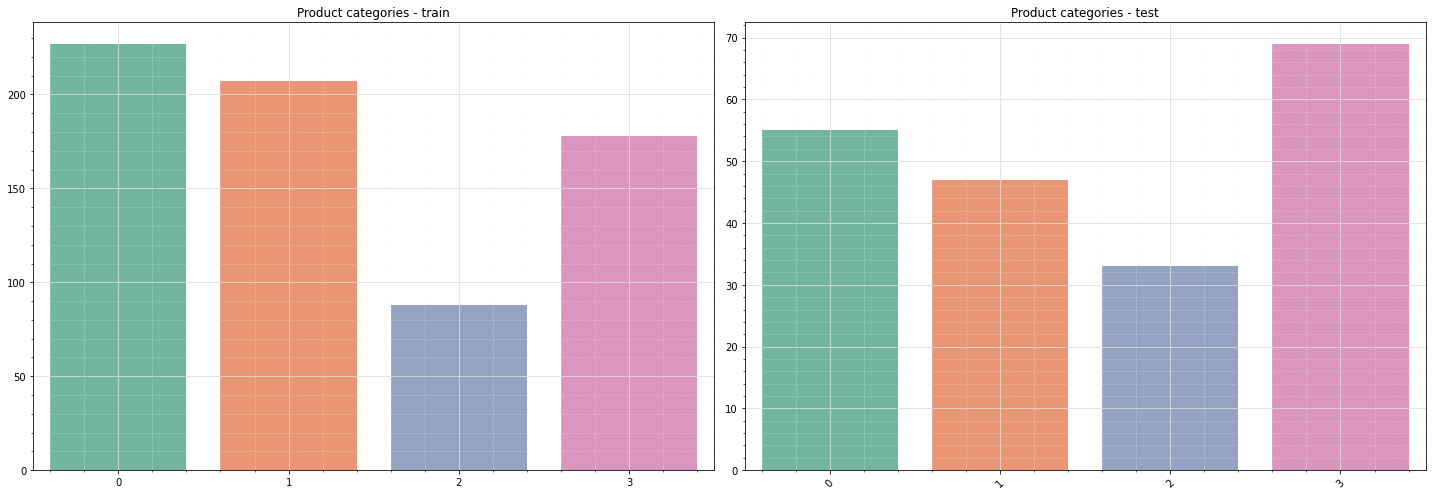

In [15]:
# Vérifier que les catégories sont bien représentées dans le train et le test

plt.figure(1, figsize = (20, 7))
# Barplot

product_categories_train = data_train['label'].value_counts()
product_categories_test = data_test['label'].value_counts()

plt.subplot(121)
sns.barplot(x = product_categories_train.index, y = product_categories_train.values)
plt.title('Product categories - train')
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()

plt.subplot(122)
sns.barplot(x = product_categories_test.index, y = product_categories_test.values)
plt.title('Product categories - test')
plt.xticks(rotation = 45)
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()

plt.tight_layout()
plt.show()

In [16]:
# dire ce qu'on fait ici
images_np = data_preparation.image_prep_fct(data_train)
images_np

array([[[[  90.061    ,   86.221    ,   82.32     ],
         [  87.061    ,   86.221    ,   81.32     ],
         [  89.061    ,   85.221    ,   81.32     ],
         ...,
         [  53.060997 ,   49.221    ,   51.32     ],
         [  54.060997 ,   50.221    ,   52.32     ],
         [  53.060997 ,   49.221    ,   51.32     ]],

        [[  99.061    ,   91.221    ,   83.32     ],
         [  98.061    ,   89.221    ,   83.32     ],
         [  98.061    ,   90.221    ,   84.32     ],
         ...,
         [  56.060997 ,   52.221    ,   54.32     ],
         [  54.060997 ,   50.221    ,   52.32     ],
         [  55.060997 ,   51.221    ,   53.32     ]],

        [[  99.061    ,   90.221    ,   84.32     ],
         [ 103.061    ,   92.221    ,   86.32     ],
         [ 103.061    ,   92.221    ,   86.32     ],
         ...,
         [  55.060997 ,   51.221    ,   53.32     ],
         [  56.060997 ,   52.221    ,   54.32     ],
         [  53.060997 ,   49.221    ,   51.32     ]],

In [17]:
images_np.shape

(700, 224, 224, 3)

In [18]:
images_np_test = data_preparation.image_prep_fct(data_test)
images_np_test

array([[[[ 150.061     ,  137.22101   ,  130.32      ],
         [ 150.061     ,  137.22101   ,  130.32      ],
         [ 150.061     ,  137.22101   ,  130.32      ],
         ...,
         [ 151.061     ,  138.22101   ,  131.32      ],
         [ 151.061     ,  138.22101   ,  131.32      ],
         [ 151.061     ,  138.22101   ,  131.32      ]],

        [[ 150.061     ,  137.22101   ,  130.32      ],
         [ 150.061     ,  137.22101   ,  130.32      ],
         [ 150.061     ,  137.22101   ,  130.32      ],
         ...,
         [ 151.061     ,  138.22101   ,  131.32      ],
         [ 151.061     ,  138.22101   ,  131.32      ],
         [ 151.061     ,  138.22101   ,  131.32      ]],

        [[ 150.061     ,  137.22101   ,  130.32      ],
         [ 150.061     ,  137.22101   ,  130.32      ],
         [ 150.061     ,  137.22101   ,  130.32      ],
         ...,
         [ 151.061     ,  138.22101   ,  131.32      ],
         [ 151.061     ,  138.22101   ,  131.32      ],
  

In [19]:
images_np_test.shape

(204, 224, 224, 3)

In [20]:
X = images_np
X

array([[[[  90.061    ,   86.221    ,   82.32     ],
         [  87.061    ,   86.221    ,   81.32     ],
         [  89.061    ,   85.221    ,   81.32     ],
         ...,
         [  53.060997 ,   49.221    ,   51.32     ],
         [  54.060997 ,   50.221    ,   52.32     ],
         [  53.060997 ,   49.221    ,   51.32     ]],

        [[  99.061    ,   91.221    ,   83.32     ],
         [  98.061    ,   89.221    ,   83.32     ],
         [  98.061    ,   90.221    ,   84.32     ],
         ...,
         [  56.060997 ,   52.221    ,   54.32     ],
         [  54.060997 ,   50.221    ,   52.32     ],
         [  55.060997 ,   51.221    ,   53.32     ]],

        [[  99.061    ,   90.221    ,   84.32     ],
         [ 103.061    ,   92.221    ,   86.32     ],
         [ 103.061    ,   92.221    ,   86.32     ],
         ...,
         [  55.060997 ,   51.221    ,   53.32     ],
         [  56.060997 ,   52.221    ,   54.32     ],
         [  53.060997 ,   49.221    ,   51.32     ]],

In [21]:
y = to_categorical(data['label'][:700])
y

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [22]:
X_test = images_np_test
X_test

array([[[[ 150.061     ,  137.22101   ,  130.32      ],
         [ 150.061     ,  137.22101   ,  130.32      ],
         [ 150.061     ,  137.22101   ,  130.32      ],
         ...,
         [ 151.061     ,  138.22101   ,  131.32      ],
         [ 151.061     ,  138.22101   ,  131.32      ],
         [ 151.061     ,  138.22101   ,  131.32      ]],

        [[ 150.061     ,  137.22101   ,  130.32      ],
         [ 150.061     ,  137.22101   ,  130.32      ],
         [ 150.061     ,  137.22101   ,  130.32      ],
         ...,
         [ 151.061     ,  138.22101   ,  131.32      ],
         [ 151.061     ,  138.22101   ,  131.32      ],
         [ 151.061     ,  138.22101   ,  131.32      ]],

        [[ 150.061     ,  137.22101   ,  130.32      ],
         [ 150.061     ,  137.22101   ,  130.32      ],
         [ 150.061     ,  137.22101   ,  130.32      ],
         ...,
         [ 151.061     ,  138.22101   ,  131.32      ],
         [ 151.061     ,  138.22101   ,  131.32      ],
  

In [23]:
data_test['label'].unique()

array([1, 0, 3, 2])

In [24]:
y_test = to_categorical(data_test['label'])
y_test

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],


In [25]:
y_test.shape

(204, 4)

In [26]:
# Train test split (split en train et en validation) 
# -> du coup on a un jeu de données train, un jeu de données validation et un jeu de données test
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify = y, test_size = 0.25, random_state = 42)
X_train.shape

(525, 224, 224, 3)

In [27]:
X_test.shape

(204, 224, 224, 3)

In [28]:
y_train.shape

(525, 4)

In [29]:
# Création du modèle
with tf.device('/gpu:0'):
    model1 = classification_supervisee.create_model_fct_1()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2024-03-18 13:28:05.426685: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-18 13:28:05.427665: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [30]:
# Création du callback
model1_save_path1 = './model1_best_weights.h5'
checkpoint = ModelCheckpoint(model1_save_path1, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
callbacks_list = [checkpoint, es]

In [31]:
# pourquoi 50 epoch
# pourquoi batch size de 64

In [32]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'):
    history1 = model1.fit(X_train, y_train, epochs = 50, batch_size = 64, callbacks = callbacks_list, validation_data = (X_val, y_val), verbose = 1)

Epoch 1/50


2024-03-18 13:28:06.381052: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-03-18 13:28:06.768504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - ETA: 0s - loss: 4.9103 - accuracy: 0.5124

2024-03-18 13:28:20.184802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.37495, saving model to ./model1_best_weights.h5
9/9 [==============================] - 18s 2s/step - loss: 4.9103 - accuracy: 0.5124 - val_loss: 1.3749 - val_accuracy: 0.8000
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 1.9666 - accuracy: 0.7371
Epoch 2: val_loss did not improve from 1.37495
9/9 [==============================] - 15s 2s/step - loss: 1.9666 - accuracy: 0.7371 - val_loss: 1.5280 - val_accuracy: 0.8114
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 1.1423 - accuracy: 0.8362
Epoch 3: val_loss did not improve from 1.37495
9/9 [==============================] - 14s 2s/step - loss: 1.1423 - accuracy: 0.8362 - val_loss: 1.4182 - val_accuracy: 0.8286
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 0.6279 - accuracy: 0.8743
Epoch 4: val_loss improved from 1.37495 to 1.32129, saving model to ./model1_best_weights.h5
9/9 [==============================] - 15s 2s/step - loss: 0.6279 

In [33]:
# choix de l'accuracy -> dire pourquoi

In [34]:
# Score du dernier epoch
loss, accuracy = model1.evaluate(X_train, y_train, verbose = True)
print('Training Accuracy: {:.4f}'.format(accuracy))

loss, accuracy = model1.evaluate(X_val, y_val, verbose = True)
print('Validation Accuracy: {:.4f}'.format(accuracy))

17/17 [==============================] - 9s 530ms/step - loss: 0.0013 - accuracy: 1.0000
Training Accuracy: 1.0000
6/6 [==============================] - 3s 481ms/step - loss: 1.1489 - accuracy: 0.8743
Validation Accuracy: 0.8743


In [35]:
# Score de l'epoch optimal
model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose = False)
print('Validation Accuracy : {:.4f}'.format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose = False)
print('Test Accuracy : {:.4f}'.format(accuracy))

Validation Accuracy : 0.8743
Test Accuracy : 0.5686


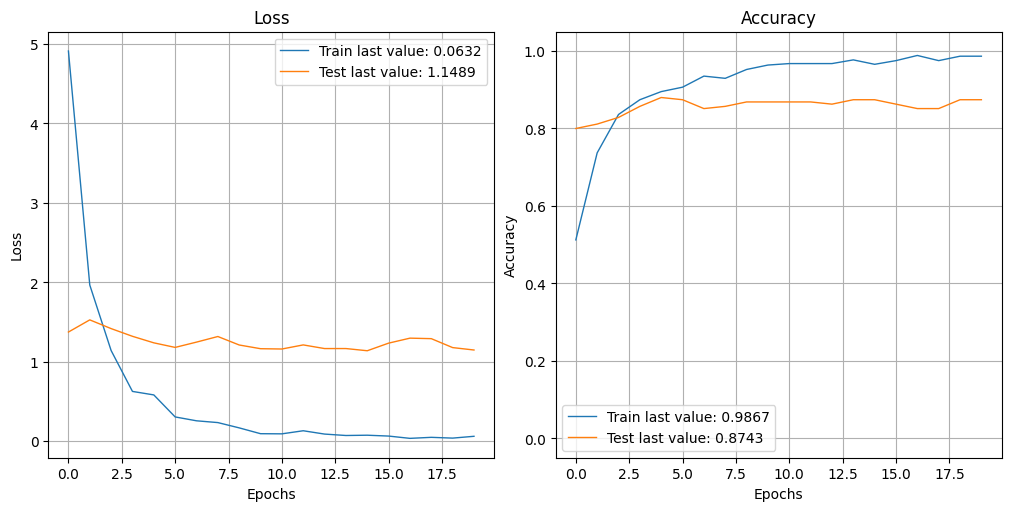

In [36]:
# plot blablabla

show_history(history1)
plot_history(history1, path = 'standard.png')
plt.close()

In [37]:
y_val_num = np.argmax(y_val, axis = 1)
print(y_val_num)

[0 1 3 0 2 1 0 3 0 2 1 1 0 3 1 1 0 0 2 1 3 1 0 3 2 1 0 0 0 0 0 0 1 1 0 1 1
 1 3 2 1 0 0 1 0 0 1 0 3 3 3 3 1 1 1 1 0 1 2 1 0 3 3 0 3 3 0 1 1 2 3 3 3 1
 3 2 3 0 1 2 0 1 1 3 3 2 3 3 0 3 0 3 0 0 1 3 3 1 2 0 3 0 2 0 3 0 0 0 3 3 0
 1 3 1 2 0 1 3 1 0 3 1 1 3 1 2 0 0 0 1 1 3 0 1 1 2 0 2 1 1 2 2 0 1 0 0 0 1
 0 1 3 0 0 1 2 3 0 0 2 1 1 1 1 3 3 3 0 3 2 3 0 3 2 0 0]


In [38]:
y_val_pred = np.argmax(model1.predict(X_val), axis = 1)
print(y_val_pred)

2024-03-18 13:33:35.897949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 3s 582ms/step
[0 1 3 3 2 1 0 3 0 3 0 1 3 3 1 1 0 0 2 1 3 1 0 3 2 1 0 0 0 0 2 0 1 1 0 1 1
 1 3 2 1 0 0 1 0 3 1 3 0 3 3 3 1 2 1 1 0 1 2 1 0 3 0 0 2 3 0 1 1 2 3 0 3 1
 0 2 3 0 1 2 0 1 1 3 3 2 3 3 0 3 1 3 0 0 1 3 0 1 2 0 3 0 2 0 3 3 0 0 3 3 0
 1 3 1 2 0 0 2 1 0 0 1 1 3 1 0 0 0 0 1 1 3 0 1 1 2 0 2 1 1 2 2 0 1 0 0 0 1
 0 1 3 0 0 1 2 3 0 0 0 1 1 1 2 3 3 3 0 3 2 3 0 3 2 0 0]


In [39]:
# Matrice de confusion

conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[50  1  1  5]
 [ 2 48  2  0]
 [ 2  0 19  1]
 [ 6  0  2 36]]


In [40]:
y_val_pred_transform = data_preparation.conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)

Correspondance des clusters :  [0 1 2 3]
[[50  1  1  5]
 [ 2 48  2  0]
 [ 2  0 19  1]
 [ 6  0  2 36]]


In [41]:
# Rapport de classification :

print(metrics.classification_report(y_val_num, y_val_pred_transform))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85        57
           1       0.98      0.92      0.95        52
           2       0.79      0.86      0.83        22
           3       0.86      0.82      0.84        44

    accuracy                           0.87       175
   macro avg       0.87      0.87      0.87       175
weighted avg       0.88      0.87      0.88       175



In [42]:
# Mise sous forme de dataframe de la matrice de confusion ?
list_labels = data['label_name'].unique().tolist()
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels], columns = [i for i in '0123'])
df_cm

,0,1,2,3
Home and Kitchen Essential,50,1,1,5
Baby and Personal Care,2,48,2,0
Electronics and Accessories,2,0,19,1
Festive and Special Occasion,6,0,2,36


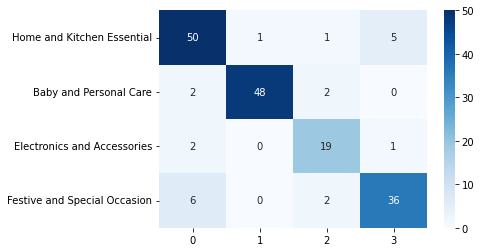

In [43]:
# Heatmap blabla

plt.figure(figsize = (6, 4))
sns.heatmap(df_cm, annot = True, cmap = 'Blues')
plt.show()

## Approche ImageDatagenerator avec data augmentation

CF https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow (noté désormais comme "deprecated", incite à utiiser l'approche suivante)

In [44]:
# Pour mélanger les images, classées initalement par classe
data = data.sample(frac = 1, random_state = 42).reset_index(drop = True)

In [45]:
data['label_name'].unique()

array(['Home and Kitchen Essential', 'Electronics and Accessories',
       'Festive and Special Occasion', 'Baby and Personal Care'],
      dtype=object)

In [46]:
data

,label_name,image_path,label
0,Home and Kitchen Essential,../../data/Images/0a8a1e9c6659361c0c2b247f8a64...,3
1,Electronics and Accessories,../../data/Images/51c9062e6538c787b14a75a6a7cb...,1
2,Festive and Special Occasion,../../data/Images/0f7a56876c61ba98dfed48ede5d3...,2
3,Baby and Personal Care,../../data/Images/ecb5bba9a5984d2b35b8ac3f5605...,0
4,Home and Kitchen Essential,../../data/Images/3388d05e88972ff9f3e1321dc0cf...,3
...,...,...,...
899,Baby and Personal Care,../../data/Images/a85a7dbd31267a7b02eda3a4d484...,0
900,Electronics and Accessories,../../data/Images/6634de7b39a5b0658c74ab098450...,1
901,Home and Kitchen Essential,../../data/Images/0c70a580d96e50966130e2885d8c...,3
902,Electronics and Accessories,../../data/Images/5db6bd89da44841c1a5b686e6713...,1


In [47]:
data = data[data['label_name'].notnull()]

In [48]:
data['label_name'] = data['label_name'].apply(lambda x : x.split(','))

In [49]:
batch_size = 32

In [50]:
data

,label_name,image_path,label
0,[Home and Kitchen Essential],../../data/Images/0a8a1e9c6659361c0c2b247f8a64...,3
1,[Electronics and Accessories],../../data/Images/51c9062e6538c787b14a75a6a7cb...,1
2,[Festive and Special Occasion],../../data/Images/0f7a56876c61ba98dfed48ede5d3...,2
3,[Baby and Personal Care],../../data/Images/ecb5bba9a5984d2b35b8ac3f5605...,0
4,[Home and Kitchen Essential],../../data/Images/3388d05e88972ff9f3e1321dc0cf...,3
...,...,...,...
899,[Baby and Personal Care],../../data/Images/a85a7dbd31267a7b02eda3a4d484...,0
900,[Electronics and Accessories],../../data/Images/6634de7b39a5b0658c74ab098450...,1
901,[Home and Kitchen Essential],../../data/Images/0c70a580d96e50966130e2885d8c...,3
902,[Electronics and Accessories],../../data/Images/5db6bd89da44841c1a5b686e6713...,1


In [51]:
# ????? expliquer ce que je fais ici

datagen_train = ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization = True,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    validation_split = 0.25,
    preprocessing_function = preprocess_input
    )

train_flow = data_preparation.data_flow_fct(batch_size, data, datagen_train, data_type = 'training')
val_flow = data_preparation.data_flow_fct(batch_size, data, datagen_train, data_type = 'validation')

datagen_test = ImageDataGenerator(
    validation_split = 0,
    preprocessing_function = preprocess_input)

#test_flow = data_flow_fct(data_test, datagen_test, data_type = None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 678 validated image filenames belonging to 4 classes.
Found 226 validated image filenames belonging to 4 classes.


In [52]:
test_flow = data_preparation.data_flow_fct(batch_size, data_test, datagen_test, data_type = None)
test_flow

Found 204 validated image filenames belonging to 4 classes.


In [53]:
data_test.head()

,label_name,image_path,label
0,Electronics and Accessories,../../data/Images/952a100cf3a5bdf2d655e9cdca0e...,1
1,Electronics and Accessories,../../data/Images/d86f260ff28af531443f822c1174...,1
2,Electronics and Accessories,../../data/Images/4354b7418ee0fab2fd9f8eb49355...,1
3,Electronics and Accessories,../../data/Images/95b0779b1a04ab70d62c72b53090...,1
4,Electronics and Accessories,../../data/Images/078b35be31e8ac99b0cbb817dab4...,1


In [54]:
data_test = data_test[data_test['label_name'].notnull()]
data_test['label_name'] = data_test['label_name'].apply(lambda x : x.split(','))
data_test.head()

,label_name,image_path,label
0,[Electronics and Accessories],../../data/Images/952a100cf3a5bdf2d655e9cdca0e...,1
1,[Electronics and Accessories],../../data/Images/d86f260ff28af531443f822c1174...,1
2,[Electronics and Accessories],../../data/Images/4354b7418ee0fab2fd9f8eb49355...,1
3,[Electronics and Accessories],../../data/Images/95b0779b1a04ab70d62c72b53090...,1
4,[Electronics and Accessories],../../data/Images/078b35be31e8ac99b0cbb817dab4...,1


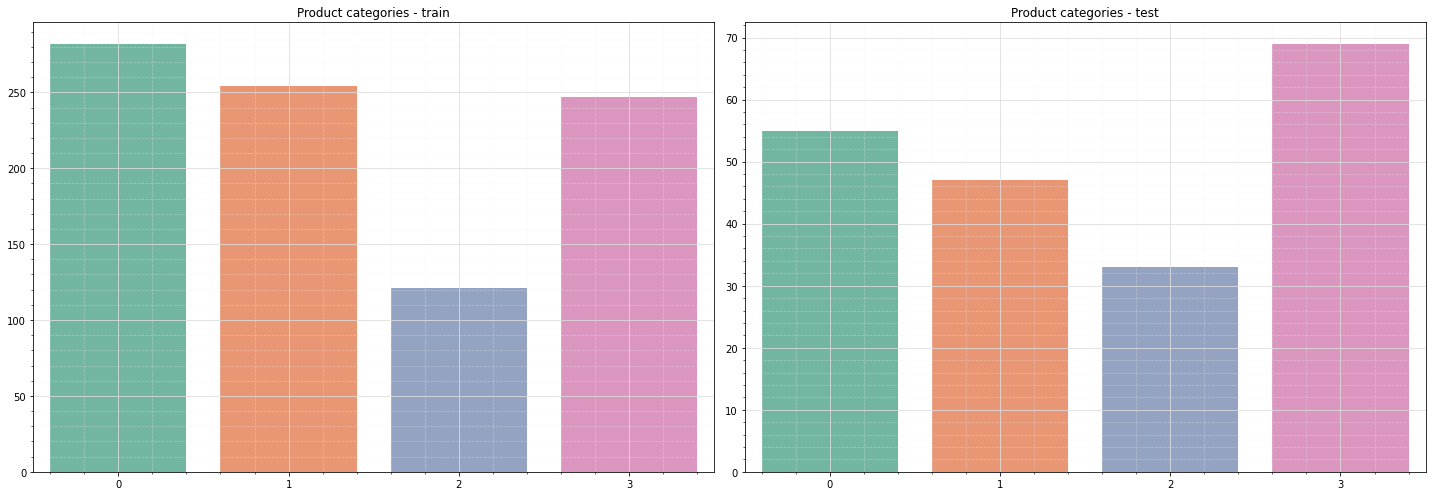

In [103]:
# Vérifier que les catégories sont bien représentées dans le train et le test

plt.figure(1, figsize = (20, 7))
# Barplot

product_categories_train = data['label'].value_counts()
product_categories_test = data_test['label'].value_counts()

plt.subplot(121)
sns.barplot(x = product_categories_train.index, y = product_categories_train.values)
plt.title('Product categories - train')
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()

plt.subplot(122)
sns.barplot(x = product_categories_test.index, y = product_categories_test.values)
plt.title('Product categories - test')
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()

plt.tight_layout()
plt.show()

In [55]:
datagen_test = ImageDataGenerator(
    validation_split = 0,
    preprocessing_function = preprocess_input)

test_flow = data_preparation.data_flow_fct(batch_size, data_test, datagen_test, data_type = None)

Found 204 validated image filenames belonging to 4 classes.


In [56]:
# Création du modèle
with tf.device('/gpu:0'):
    model2 = classification_supervisee.create_model_fct_1()

# Création du callback
model2_save_path = './model2_best_weights.h5'
checkpoint = ModelCheckpoint(model2_save_path, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
callbacks_list = [checkpoint, es]

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [57]:
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [59]:
with tf.device('/gpu:0'):
    history2 = model2.fit(
        train_flow,
        validation_data = val_flow,
        batch_size = batch_size,
        epochs = 50,
        callbacks = callbacks_list,
        verbose = 1
        )

Epoch 1/50


2024-03-18 13:33:41.467679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - ETA: 0s - loss: 3.1529 - accuracy: 0.5265

2024-03-18 13:33:58.310286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.19010, saving model to ./model2_best_weights.h5
22/22 [==============================] - 23s 1s/step - loss: 3.1529 - accuracy: 0.5265 - val_loss: 1.1901 - val_accuracy: 0.7434
Epoch 2/50
22/22 [==============================] - ETA: 0s - loss: 1.3370 - accuracy: 0.7581
Epoch 2: val_loss improved from 1.19010 to 1.04422, saving model to ./model2_best_weights.h5
22/22 [==============================] - 21s 944ms/step - loss: 1.3370 - accuracy: 0.7581 - val_loss: 1.0442 - val_accuracy: 0.7566
Epoch 3/50
22/22 [==============================] - ETA: 0s - loss: 0.9053 - accuracy: 0.7802
Epoch 3: val_loss improved from 1.04422 to 1.04316, saving model to ./model2_best_weights.h5
22/22 [==============================] - 21s 947ms/step - loss: 0.9053 - accuracy: 0.7802 - val_loss: 1.0432 - val_accuracy: 0.7522
Epoch 4/50
22/22 [==============================] - ETA: 0s - loss: 0.6630 - accuracy: 0.8083
Epoch 4: val_loss improved from 1.04316 to 0.9071

In [60]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose = True)
print('Training Accuracy : {:.4f}'.format(accuracy))

loss, accuracy = model2.evaluate(val_flow, verbose = True)
print('Validation Accuracy : {:.4f}'.format(accuracy))

22/22 [==============================] - 16s 690ms/step - loss: 0.0772 - accuracy: 0.9676
Training Accuracy : 0.9676
8/8 [==============================] - 6s 601ms/step - loss: 0.7554 - accuracy: 0.7832
Validation Accuracy : 0.7832


In [61]:
# Score de l'epoch optimal
model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose = False)
print('Validation Accuracy : {:.4f}'.format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose = False)
print('Test Accuracy : {:.4f}'.format(accuracy))

Validation Accuracy : 0.8186
Test Accuracy : 0.8529


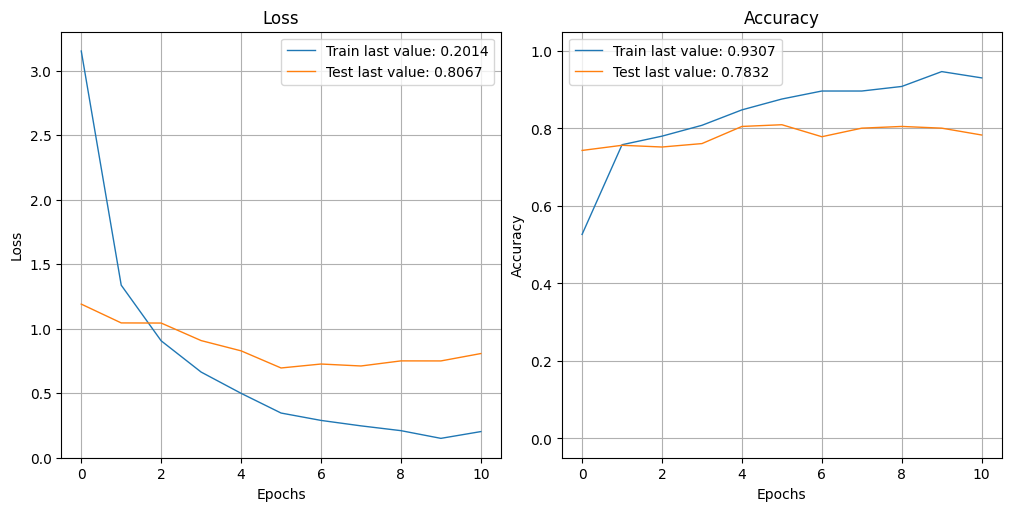

In [62]:
# plot blabla

show_history(history2)
plot_history(history2, path = 'standard.png')
plt.close()

## Approche nouvelle par Dataset sans data augmentation

tutoriel : https://www.tensorflow.org/tutorials/load_data/images

In [63]:
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory?utm_medium=email&utm_content=nov-18-has-completed-mentoring-session-student&bsft_clkid=7e7fcb5c-d2a5-4e5f-914e-7884d0b2fc1d&bsft_uid=3eac5941-ee98-433b-9ab8-a486990fcfdc&bsft_mid=57c0f452-3d55-4726-a8b5-e4e5d5294b7c&bsft_eid=7244055d-47f0-a6f2-c394-7a20ebb3a726&bsft_txnid=e812e4b6-3e28-4958-87b7-5751d7b01471&bsft_mime_type=html&bsft_ek=2024-03-01T15%3A37%3A01Z&bsft_aaid=a265d396-7432-4eb2-9c9a-ba5eea75629e&bsft_tv=14

In [64]:
# problème : dans exemple, chaque catégorie/label d'image est dans un sous-dossier différent
# comment ajouter l'information liée aux labels d'une autre façon ?

# labels = inferred -> labels are generated from the directory structure - pas possible aussi, nécessiterait de classer manuellement chaque image dans le bon dossier
# labels = None -> no labels
# dernière option -> list/tuple of integer labels of the same size as the number of image files found in the directory
# attention, avec la dernière option : Labels should be sorted according to the alphanumeric order of the image file paths (obtained via os.walk(directory) in Python)

In [65]:
# problème de données manquantes : pas le même nombre d'images dans le dossier vs le nb de lignes dans le dataframe

In [ ]:
# regarder os.move et déplacer images qui ne sont pas dans le dataset (plutot que d'essayer de les supprimer)

In [66]:
# S'assurer de l'ordre de lecture des images par l'ordinateur
for (root, dirs, files_train) in os.walk('/Users/lucilerabeau/code/LucileRb/classification_auto_consommation/data/Images_train/train/'):
    print(root)
    print(dirs)
    print(files_train) # liste des images dans l'ordre de lecture

/Users/lucilerabeau/code/LucileRb/classification_auto_consommation/data/Images_train/train/
[]
['aa68675f50a0551b8dadb954017a50a1.jpg', '037c2402fee39fbc80433935711d1383.jpg', '42643c1c9403f67921a18654bcf45ead.jpg', '53f4bc7d7321f5c41de6b86e41f13e80.jpg', '9a9402ad55d079c86c302521816b7b0e.jpg', '42a8fef62716772c391fbdd148cc9c16.jpg', '503bb08f7bdf6a395ec564dd1dc83619.jpg', '42770faa04bfcf2b62e7ef335e1b1965.jpg', '9c4ab8ab059c912090c83cb0818e7f1c.jpg', 'a618354ba17cff64826558d81afc77ab.jpg', '1d829e0eac91d7e85cdd6d581c363360.jpg', '5c7b493625b5fc6689cae49d25e1ae17.jpg', '06749cbff1487f470438823f6952cfd1.jpg', '473b1ab1abe21826c41efa1584a88a63.jpg', '07912328f580cf080d721e6466287896.jpg', '5cd3d274d71e1e0d6bf075421461b2d5.jpg', '7264f56639c8c54158b94ced769082c8.jpg', '0991e8d8f884003ab18890971191085d.jpg', '32da1bbf4f523bc8a8735701ce4b7726.jpg', '90453db0386931707b256dfa1e32c404.jpg', '40829ac110f344ef35f1c8c32fb311c7.jpg', '4b0e6f200426b1db8824b2ca0c59ecfa.jpg', '3fd4d7ea04624ada39fde39

In [67]:
files_train

['aa68675f50a0551b8dadb954017a50a1.jpg',
 '037c2402fee39fbc80433935711d1383.jpg',
 '42643c1c9403f67921a18654bcf45ead.jpg',
 '53f4bc7d7321f5c41de6b86e41f13e80.jpg',
 '9a9402ad55d079c86c302521816b7b0e.jpg',
 '42a8fef62716772c391fbdd148cc9c16.jpg',
 '503bb08f7bdf6a395ec564dd1dc83619.jpg',
 '42770faa04bfcf2b62e7ef335e1b1965.jpg',
 '9c4ab8ab059c912090c83cb0818e7f1c.jpg',
 'a618354ba17cff64826558d81afc77ab.jpg',
 '1d829e0eac91d7e85cdd6d581c363360.jpg',
 '5c7b493625b5fc6689cae49d25e1ae17.jpg',
 '06749cbff1487f470438823f6952cfd1.jpg',
 '473b1ab1abe21826c41efa1584a88a63.jpg',
 '07912328f580cf080d721e6466287896.jpg',
 '5cd3d274d71e1e0d6bf075421461b2d5.jpg',
 '7264f56639c8c54158b94ced769082c8.jpg',
 '0991e8d8f884003ab18890971191085d.jpg',
 '32da1bbf4f523bc8a8735701ce4b7726.jpg',
 '90453db0386931707b256dfa1e32c404.jpg',
 '40829ac110f344ef35f1c8c32fb311c7.jpg',
 '4b0e6f200426b1db8824b2ca0c59ecfa.jpg',
 '3fd4d7ea04624ada39fde3957c7b9b7c.jpg',
 '5479bb7028827d60000720a2c135976a.jpg',
 '6136976dc5a433

In [68]:
df_image

,label_name,product_category_tree,image_name,image_path,label
0,Home and Kitchen Essential,"[""Home Furnishing >> Curtains & Accessories >>...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,../../data/Images/55b85ea15a1536d46b7190ad6fff...,3
1,Baby and Personal Care,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",7b72c92c2f6c40268628ec5f14c6d590.jpg,../../data/Images/7b72c92c2f6c40268628ec5f14c6...,0
2,Home and Kitchen Essential,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",d4684dcdc759dd9cdf41504698d737d8.jpg,../../data/Images/d4684dcdc759dd9cdf41504698d7...,3
3,Home and Kitchen Essential,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",6325b6870c54cd47be6ebfbffa620ec7.jpg,../../data/Images/6325b6870c54cd47be6ebfbffa62...,3
4,Electronics and Accessories,"[""Watches >> Wrist Watches >> Camerii Wrist Wa...",f355cc1ccb08bd0d283ed979b7ee7515.jpg,../../data/Images/f355cc1ccb08bd0d283ed979b7ee...,1
...,...,...,...,...,...
934,Baby and Personal Care,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",38782cce965307ddcdbedfcb7fa409c3.jpg,../../data/Images/38782cce965307ddcdbedfcb7fa4...,0
935,Baby and Personal Care,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",be0f39341d771aac57084970f1ed6425.jpg,../../data/Images/be0f39341d771aac57084970f1ed...,0
936,Baby and Personal Care,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",958f54f4c46b53c8a0a9b8167d9140bc.jpg,../../data/Images/958f54f4c46b53c8a0a9b8167d91...,0
937,Baby and Personal Care,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,../../data/Images/c3edc504d1b4f0ba6224fa53a43a...,0


In [82]:
files_train

['aa68675f50a0551b8dadb954017a50a1.jpg',
 '037c2402fee39fbc80433935711d1383.jpg',
 '42643c1c9403f67921a18654bcf45ead.jpg',
 '53f4bc7d7321f5c41de6b86e41f13e80.jpg',
 '9a9402ad55d079c86c302521816b7b0e.jpg',
 '42a8fef62716772c391fbdd148cc9c16.jpg',
 '503bb08f7bdf6a395ec564dd1dc83619.jpg',
 '42770faa04bfcf2b62e7ef335e1b1965.jpg',
 '9c4ab8ab059c912090c83cb0818e7f1c.jpg',
 'a618354ba17cff64826558d81afc77ab.jpg',
 '1d829e0eac91d7e85cdd6d581c363360.jpg',
 '5c7b493625b5fc6689cae49d25e1ae17.jpg',
 '06749cbff1487f470438823f6952cfd1.jpg',
 '473b1ab1abe21826c41efa1584a88a63.jpg',
 '07912328f580cf080d721e6466287896.jpg',
 '5cd3d274d71e1e0d6bf075421461b2d5.jpg',
 '7264f56639c8c54158b94ced769082c8.jpg',
 '0991e8d8f884003ab18890971191085d.jpg',
 '32da1bbf4f523bc8a8735701ce4b7726.jpg',
 '90453db0386931707b256dfa1e32c404.jpg',
 '40829ac110f344ef35f1c8c32fb311c7.jpg',
 '4b0e6f200426b1db8824b2ca0c59ecfa.jpg',
 '3fd4d7ea04624ada39fde3957c7b9b7c.jpg',
 '5479bb7028827d60000720a2c135976a.jpg',
 '6136976dc5a433

In [84]:
df_files_train = pd.DataFrame()
df_files_train['image_name'] = files_train
df_files_train

,image_name
0,aa68675f50a0551b8dadb954017a50a1.jpg
1,037c2402fee39fbc80433935711d1383.jpg
2,42643c1c9403f67921a18654bcf45ead.jpg
3,53f4bc7d7321f5c41de6b86e41f13e80.jpg
4,9a9402ad55d079c86c302521816b7b0e.jpg
...,...
696,9b00cab981ab825158c05c9e54b866d4.jpg
697,4e5ebfc871992e7e22365c0c036a1b89.jpg
698,82fbc93cd45ab747e7e606f2c52c7335.jpg
699,216c6c3527984be3d7ad9023d5cd9bd1.jpg


In [85]:
# utiliser df_image et mapper labels sur files train
df_files_train['label'] = df_files_train['image_name'].map(df_image.set_index('image_name')['label'])
df_files_train

,image_name,label
0,aa68675f50a0551b8dadb954017a50a1.jpg,NaN
1,037c2402fee39fbc80433935711d1383.jpg,3.0
2,42643c1c9403f67921a18654bcf45ead.jpg,0.0
3,53f4bc7d7321f5c41de6b86e41f13e80.jpg,NaN
4,9a9402ad55d079c86c302521816b7b0e.jpg,1.0
...,...,...
696,9b00cab981ab825158c05c9e54b866d4.jpg,2.0
697,4e5ebfc871992e7e22365c0c036a1b89.jpg,0.0
698,82fbc93cd45ab747e7e606f2c52c7335.jpg,2.0
699,216c6c3527984be3d7ad9023d5cd9bd1.jpg,2.0


In [97]:
# drop nan pour ne pas prendre les images non catégorisées
df_files_train.dropna(inplace = True)

In [98]:
# reduire pour ne garder que les images du dossier train
df_image_train = df_image.loc[df_image['image_name'].isin(files_train)]
df_image_train.shape

(629, 5)

In [99]:
# sort df_image en utilisant liste d'images
df_image_train['image_name'] = df_image_train['image_name'].astype('category')
df_image_train['image_name'] = df_image_train['image_name'].cat.set_categories(files_train)
df_image_train.sort_values(['image_name'])

# faire la liste des labels
labels_train = df_image_train['label'].tolist()
len(labels_train)

629

In [100]:
# même chose pour dossier test
for (root, dirs, files_test) in os.walk('/Users/lucilerabeau/code/LucileRb/classification_auto_consommation/data/Images_test/test'):
    print(root)
    print(dirs)
    print(files_test) # liste des images dans l'ordre de lecture
    print(len(files_test))

# reduire pour ne garder que les images du dossier test
df_image_test = df_image.loc[df_image['image_name'].isin(files_test)]

# sort df_image en utilisant liste d'images
df_image_test['image_name'] = df_image_test['image_name'].astype('category')
df_image_test['image_name'] = df_image_test['image_name'].cat.set_categories(files_test)
df_image_test.sort_values(['image_name'])

# faire la liste des labels
labels_test = df_image_test['label'].tolist()
len(labels_test)

/Users/lucilerabeau/code/LucileRb/classification_auto_consommation/data/Images_test/test
[]
['aa68675f50a0551b8dadb954017a50a1.jpg', 'b144a363c107c7bdd91f32d6e28ba6f2.jpg', 'db3e2eeb4fe90d4755f2911d661eae95.jpg', 'f2fa99bfaa4aa65a2bd53337e140f949.jpg', 'a618354ba17cff64826558d81afc77ab.jpg', 'c063d07d78a55a21bf6c0e7c8ae46a6d.jpg', 'e99d9abb115a9bd580bcccf9ff4d4881.jpg', 'ab3f4b2d2ec007b7e0eaec213bfdbffc.jpg', 'e47b9f88b773b3fd97ab3b51642ff6fb.jpg', 'aadbc3b9c32c4535b1bfee7321c4c0e7.jpg', 'e80e5151787eb21b0cca0d7dc3b0c338.jpg', 'cab75cad4b3a3c593c753a1759df28e2.jpg', 'b6c339777814451815fe7950fd4c8536.jpg', 'e2cec0756030a25f294ead3acc0570d2.jpg', 'ed9817e8960a6a0d509061c54cfe5ac1.jpg', 'd21409978f5e404b53f89e444f7893fe.jpg', 'edb97bd2433fd9de301c8a44344777bb.jpg', 'cc2acb156df3202f172b280132ab459a.jpg', 'e1b2b3ad430dd738d958292441b6d046.jpg', 'b7ef3e6ec248f17f3a6a4697120ddb96.jpg', 'fd369a1bb58ae02cd925dda7e9e1d00a.jpg', 'f4d4c2eec77732f56e47722d7a355f2b.jpg', 'dea88a5f46d5fc19236651e6b3

301

In [89]:
batch_size = 32

In [90]:
def dataset_fct(batch_size, path, labels = None, validation_split = 0, data_type = None):
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels = labels, label_mode = 'int',
                    class_names = None, batch_size = batch_size, image_size = (224, 224), shuffle = True, seed = 42,
                    validation_split = validation_split, subset = data_type
                    )
    return dataset

In [91]:
# ici nécessite d'avoir images train et test dans 2 dossiers différents
# -> séparer les images dans deux dossiers (train et test)

In [92]:
path = '/Users/lucilerabeau/code/LucileRb/classification_auto_consommation/data/Images_train/'
path_test = '/Users/lucilerabeau/code/LucileRb/classification_auto_consommation/data/Images_test/'

In [93]:
#dataset_train = dataset_fct(batch_size, path, labels = labels_train, validation_split = 0.25, data_type = 'training')
#dataset_val = dataset_fct(batch_size, path, labels = labels_train, validation_split = 0.25, data_type = 'validation')
#dataset_test = dataset_fct(batch_size, path_test, labels = labels_test, validation_split = 0, data_type = None)

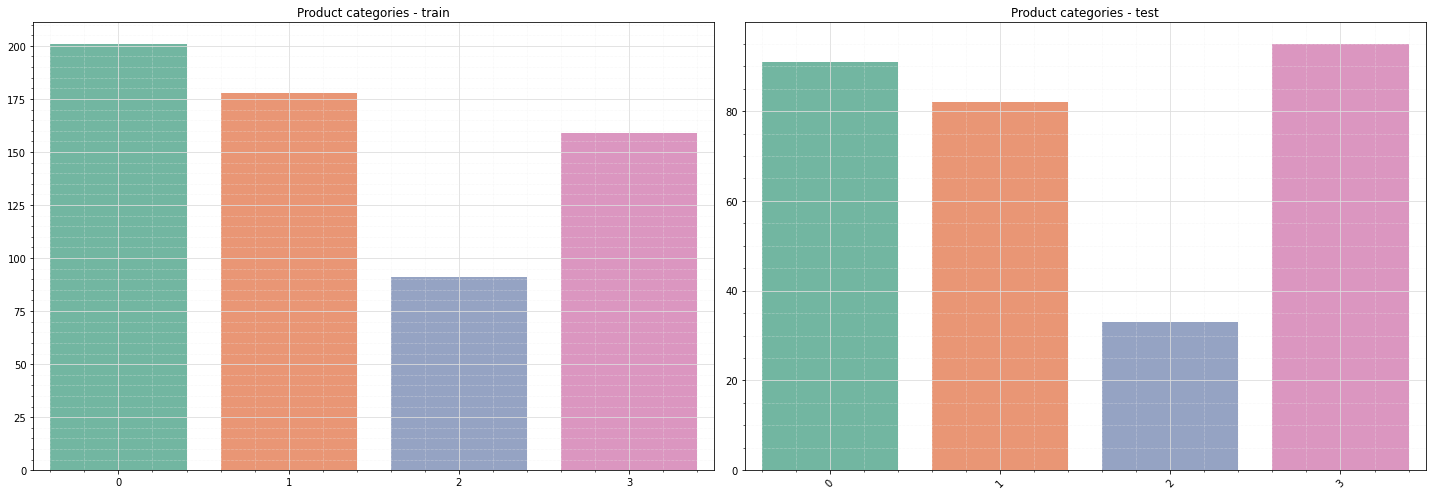

In [94]:
# Vérifier que les catégories sont bien représentées dans le train et le test

plt.figure(1, figsize = (20, 7))
# Barplot

product_categories_train = df_image_train['label'].value_counts()
product_categories_test = df_image_test['label'].value_counts()

plt.subplot(121)
sns.barplot(x = product_categories_train.index, y = product_categories_train.values)
plt.title('Product categories - train')
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()

plt.subplot(122)
sns.barplot(x = product_categories_test.index, y = product_categories_test.values)
plt.title('Product categories - test')
plt.xticks(rotation = 45)
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()

plt.tight_layout()
plt.show()

In [96]:
dataset_train = data_preparation.dataset_fct(batch_size, path, labels = labels_train, validation_split = 0.25, data_type = 'training')
dataset_val = data_preparation.dataset_fct(batch_size, path, labels = labels_train, validation_split = 0.25, data_type = 'validation')

ValueError: Expected the lengths of `labels` to match the number of files in the target directory. len(labels) is 629 while we found 700 files in /Users/lucilerabeau/code/LucileRb/classification_auto_consommation/data/Images_train/.

In [ ]:
dataset_test = data_preparation.dataset_fct(batch_size, path_test, labels = labels_test, validation_split = 0, data_type = None)

ValueError: Expected the lengths of `labels` to match the number of files in the target directory. len(labels) is 301 while we found 343 files in /Users/lucilerabeau/code/LucileRb/classification_auto_consommation/data/Images_test/.

In [ ]:
# Création du modèle
with tf.device('/gpu:0'):
    model3 = classification_supervisee.create_model_fct_2()

# Création du callback
model3_save_path = './model3_best_weights.h5'
checkpoint = ModelCheckpoint(model3_save_path, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
callbacks_list = [checkpoint, es]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
dataset_train

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
with tf.device('/gpu:0'):
    history3 = model3.fit(
        dataset_train,
        validation_data = dataset_val,
        batch_size = batch_size,
        epochs = 50,
        callbacks = callbacks_list,
        verbose = 1
        )

Epoch 1/50


2024-03-11 12:19:29.375892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 9.2121 - accuracy: 0.2781

2024-03-11 12:19:41.042504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 5.13301, saving model to ./model3_best_weights.h5
17/17 [==============================] - 16s 817ms/step - loss: 9.2121 - accuracy: 0.2781 - val_loss: 5.1330 - val_accuracy: 0.2800
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 5.2001 - accuracy: 0.3600
Epoch 2: val_loss improved from 5.13301 to 3.89259, saving model to ./model3_best_weights.h5
17/17 [==============================] - 14s 750ms/step - loss: 5.2001 - accuracy: 0.3600 - val_loss: 3.8926 - val_accuracy: 0.2114
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 3.7506 - accuracy: 0.3905
Epoch 3: val_loss improved from 3.89259 to 3.24956, saving model to ./model3_best_weights.h5
17/17 [==============================] - 14s 744ms/step - loss: 3.7506 - accuracy: 0.3905 - val_loss: 3.2496 - val_accuracy: 0.2457
Epoch 4/50
17/17 [==============================] - ETA: 0s - loss: 2.6751 - accuracy: 0.4286
Epoch 4: val_loss improved from 3.24956 to 2.9

In [ ]:
# attention avec la loss
# si labels sont one-hot-encodés -> categorical_crossentropy
# si labels sont des ints -> sparse_categorical_crossentropy

# avantage de categorical_crossentropy -> peut donner class probabilities

# si labels sont binaires -> binary_categorical_crossentropy (aussi besoin de modifier la fonction d'activation en Sigmoid)

In [ ]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_train, verbose = True)
print('Training Accuracy : {:.4f}'.format(accuracy))

loss, accuracy = model3.evaluate(dataset_val, verbose = True)
print('Validation Accuracy : {:.4f}'.format(accuracy))

17/17 [==============================] - 11s 522ms/step - loss: 0.2475 - accuracy: 0.8724
Training Accuracy : 0.8724
6/6 [==============================] - 4s 476ms/step - loss: 2.8815 - accuracy: 0.2571
Validation Accuracy : 0.2571


In [ ]:
# Score de l'epoch optimal
model3.load_weights(model3_save_path)

loss, accuracy = model3.evaluate(dataset_val, verbose = False)
print('Validation Accuracy : {:.4f}'.format(accuracy))

loss, accuracy = model3.evaluate(dataset_test, verbose = False)
print('Test Accuracy : {:.4f}'.format(accuracy))


Validation Accuracy : 0.2114
Test Accuracy : 0.2600


In [ ]:
# est-ce que les catégories sont bien balancées dans mon train et mon test ?
# accuracy du test -> 0.25 - equivalent à ce qu'on aurait si on prenait une catégorie au hasard (1 chance sur 4)

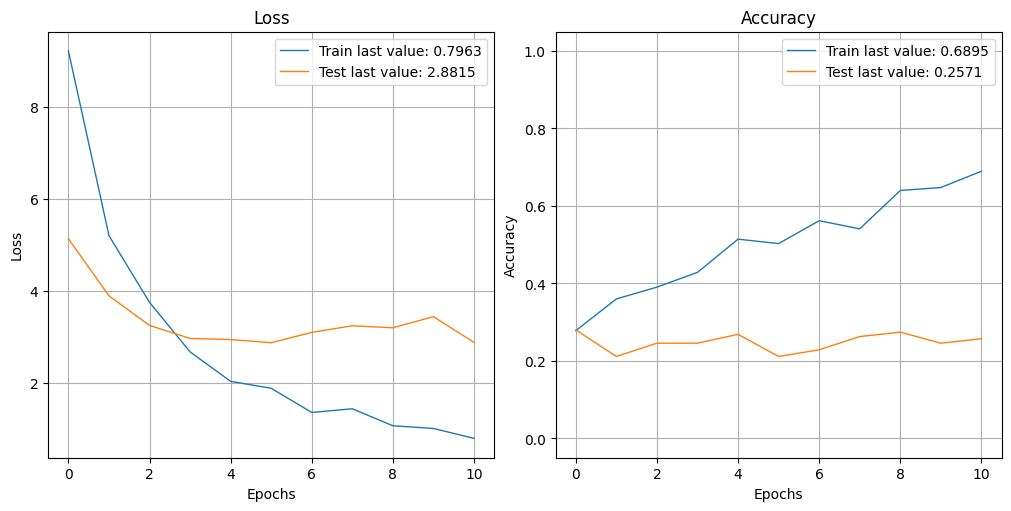

In [ ]:
# plot blablabla

show_history(history3)
plot_history(history3, path = 'standard.png')
plt.close()

## Approche nouvelle par Dataset avec data augmentation intégrée au modèle

CF https://www.tensorflow.org/tutorials/images/data_augmentation

In [ ]:
# data augmentation -> fait appel à la carte graphique
# vérifier les bons installs

In [ ]:
batch_size = 32

In [ ]:
#dataset_train = fonctions.dataset_fct(batch_size, path, validation_split = 0.25, data_type = 'training')
#dataset_val = fonctions.dataset_fct(batch_size, path, validation_split = 0.25, data_type = 'validation')
#dataset_test = fonctions.dataset_fct(batch_size, path_test, validation_split = 0, data_type = None)

In [ ]:
dataset_train = dataset_fct(batch_size, path, labels = labels_train, validation_split = 0.25, data_type = 'training')
dataset_val = dataset_fct(batch_size, path, labels = labels_train, validation_split = 0.25, data_type = 'validation')
dataset_test = dataset_fct(batch_size, path_test, labels = labels_test, validation_split = 0, data_type = None)

Found 700 files belonging to 1 classes.
Using 525 files for training.
Found 700 files belonging to 1 classes.
Using 175 files for validation.
Found 350 files belonging to 1 classes.


In [ ]:
def create_model_fct2():
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip('horizontal', input_shape = (224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])

    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top = False, weights = 'imagenet', input_shape = (224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset = -1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation = 'relu'),
                Dropout(0.5),
                Dense(4, activation = 'softmax')
                ])

    # compilation du modèle 
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    print(model.summary())

    return model

In [ ]:
# Création du modèle
with tf.device("/gpu:0"):
    #model4 = fonctions.create_model_fct2()
    model4 = create_model_fct2()

# Création du callback
model4_save_path = './model4_best_weights.h5'
checkpoint = ModelCheckpoint(model4_save_path, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
callbacks_list = [checkpoint, es]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                      

In [ ]:
tf.config.set_soft_device_placement(True) 

In [ ]:
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
with tf.device('/gpu:0'):
    history4 = model4.fit(
        dataset_train,
        validation_data = dataset_val,
        batch_size = batch_size,
        epochs = 50,
        callbacks = callbacks_list,
        verbose = 1
        )

Epoch 1/50


2024-03-11 12:23:24.757027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 1.4510 - accuracy: 0.2343

2024-03-11 12:23:40.281342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.30064, saving model to ./model4_best_weights.h5
17/17 [==============================] - 21s 1s/step - loss: 1.4510 - accuracy: 0.2343 - val_loss: 1.3006 - val_accuracy: 0.2914
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 1.3254 - accuracy: 0.2819
Epoch 2: val_loss improved from 1.30064 to 1.30010, saving model to ./model4_best_weights.h5
17/17 [==============================] - 17s 903ms/step - loss: 1.3254 - accuracy: 0.2819 - val_loss: 1.3001 - val_accuracy: 0.2800
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 1.2903 - accuracy: 0.3029
Epoch 3: val_loss did not improve from 1.30010
17/17 [==============================] - 17s 885ms/step - loss: 1.2903 - accuracy: 0.3029 - val_loss: 1.3101 - val_accuracy: 0.2914
Epoch 4/50
17/17 [==============================] - ETA: 0s - loss: 1.2780 - accuracy: 0.3276
Epoch 4: val_loss did not improve from 1.30010
17/17 [==============================] - 17s 925

In [ ]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(dataset_train, verbose = True)
print('Training Accuracy : {:.4f}'.format(accuracy))

loss, accuracy = model4.evaluate(dataset_val, verbose = True)
print('Validation Accuracy : {:.4f}'.format(accuracy))

17/17 [==============================] - 11s 540ms/step - loss: 1.1905 - accuracy: 0.3962
Training Accuracy : 0.3962
6/6 [==============================] - 4s 504ms/step - loss: 1.3609 - accuracy: 0.2343
Validation Accuracy : 0.2343


In [ ]:
# Score de l'epoch optimal
model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(dataset_val, verbose = False)
print('Validation Accuracy : {:.4f}'.format(accuracy))

loss, accuracy = model4.evaluate(dataset_test, verbose = False)
print('Test Accuracy : {:.4f}'.format(accuracy))


Validation Accuracy : 0.2800
Test Accuracy : 0.2943


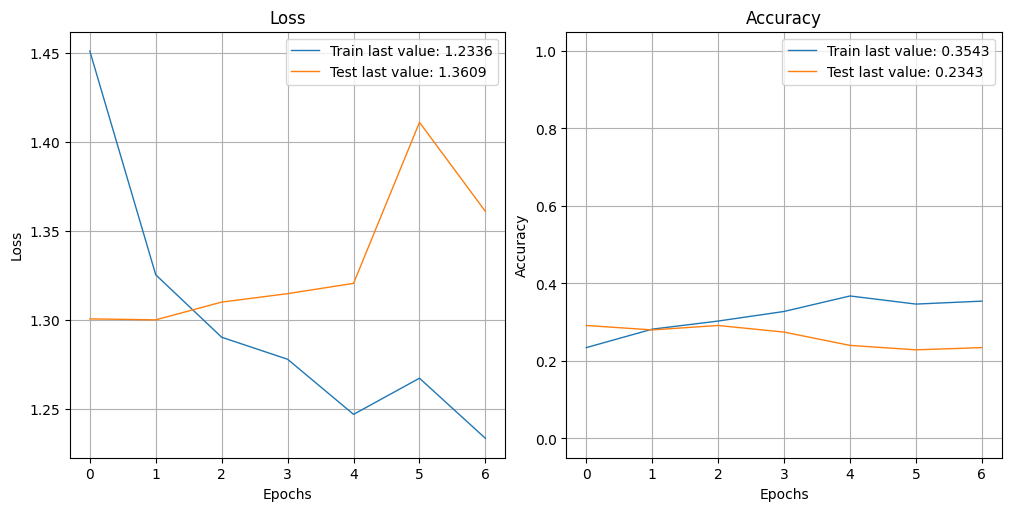

In [ ]:
# plot blablabla

show_history(history4)
plot_history(history4, path = 'standard.png')
plt.close()

In [ ]:
# si données désequilibrées -> data augmentation ne va pas aider les perfs
# bien comprendre comment fonctionne la data augmentation pour être sûre que ça ne déséquilibre pas les données

In [ ]:
# si performances ne sont pas améliorées avec des catégories bien équilibrées dans le train et le test -> argumenter en mettant en avant la faible qualité/fiabilité des labels (mais ne pas les refaire moi même)
# proposer pourquoi pas une approche non supervisée etc...